<a href="https://colab.research.google.com/github/sm354/COL870-Assignment-1/blob/main/2_1_1_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
Expname = 'BiLSTM_random'
pre_embeddings= "random" # glove or random
rootpath = "/content/drive/MyDrive/Q2_DL/Experiments/"

!pip install seqeval

import torch
torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
from torch.utils.data import Dataset, DataLoader, TensorDataset
import io
import sklearn
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
import seqeval
from seqeval.metrics import accuracy_score as seq_accuracy_score
from seqeval.metrics import classification_report as seq_classification_report
from seqeval.metrics import f1_score as seq_f1_score

if torch.cuda.is_available():  
  device = "cuda:0" 
else:  
  device = "cpu"  

# device = "cpu"

from google.colab import drive
drive.mount('/content/drive')

# reading text file in python and making list of sentences (list of lists) and list of tags(list of lists)
def load_data(datapath, buildvocab_tags= True, vocab = None, nertags = None):
    if(buildvocab_tags == True):
        all_words = []
        all_tags = []
        with open(datapath) as f:
            lines = f.readlines()
            sent_num = 0
            for line in lines[1:]: #1: so that the first blank line isn't taken into account
                if(line == "\n"):
                    sent_num+=1
                else:
                    line_sep = line.split(sep = " ")
                    all_words.append(line_sep[0])
                    all_tags.append(line_sep[3][:-1])
                    
        words = list(set(all_words))
        tags = list(set(all_tags))

        vocab = {}
        vocab['<pad>'] = 0 # for padding input sequences
        vocab['<oov>'] = 1
        for i, word in enumerate(words):
            vocab[word] = i+2
            
        nertags = {}
        nertags['padtag'] = 0
        for i,nertag in enumerate(tags):
            nertags[nertag] = i+1
        # nertags['padtag'] = len(nertags)


    train_sent = []
    train_tags = []
    with open(datapath) as f:
        lines = f.readlines()
        sent_num = 0
        sentence = []
        tag = []
        for line in lines[1:]: #1: so that the first blank line isn't taken into account
            if(line == "\n"):
                sent_num+=1
                train_sent.append(sentence)
                train_tags.append(tag)
                sentence = []
                tag = []
            else:
                line_sep = line.split(sep = " ")
                if(line_sep[0] in vocab.keys()):
                    sentence.append(vocab[line_sep[0]])
                else:
                    sentence.append(vocab['<oov>'])
                    
                tag.append(nertags[line_sep[3][:-1]])

    # padding the sentences at the end
    seq_maxlen = max(len(x) for x in train_sent)
    x_lengths = [len(x) for x in train_sent]
    Xtrain = []
    Ytrain = []
    for sent, tags in zip(train_sent, train_tags):
        length_toappend = seq_maxlen - len(sent)
        Xtrain.append(sent+[nertags['padtag']]*length_toappend)
        Ytrain.append(tags+[nertags['padtag']]*length_toappend)


    Xtrain = torch.Tensor(Xtrain)
    Ytrain = torch.Tensor(Ytrain)
    x_lengths = torch.Tensor(x_lengths)
    # print(Xtrain.shape, Ytrain.shape, x_lengths.shape)
    
    return Xtrain, Ytrain, x_lengths, vocab, nertags


"""### Training Data
### using dataloader to make data batches"""

traindatapath = "/content/drive/MyDrive/Q2_DL/train.txt"
devdatapath = "/content/drive/MyDrive/Q2_DL/dev.txt"

Xtrain, Ytrain, x_trainlengths, vocab, nertags = load_data(traindatapath, buildvocab_tags=True)
Xdev, Ydev, x_devlengths, _, _ = load_data(devdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

traindataset = TensorDataset(Xtrain, Ytrain, x_trainlengths)
Trainloader = DataLoader(traindataset, batch_size= 128, shuffle=True)

devdataset = TensorDataset(Xdev, Ydev, x_devlengths)
Devloader = DataLoader(devdataset, batch_size = 128)

embedding_size = 100
if(pre_embeddings == "glove"):
    gloveembeddings_index = {}
    with io.open("/content/drive/MyDrive/Q2_DL/glove.6B.100d.txt", encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:],dtype='float32')
            gloveembeddings_index[word] = coefs

    #using vocab and Xtrain, Xvalid, get pretrained glove word embeddings
    glove_embeds = np.zeros((len(vocab), embedding_size))
    for word in vocab.keys():
        if(word in gloveembeddings_index.keys()):
            # for the pad word let theembedding be all zeros
            glove_embeds[vocab[word]] = gloveembeddings_index[word]
        else:
            glove_embeds[vocab[word]] = np.random.randn(embedding_size)
    word_embeds = torch.Tensor(glove_embeds)
    # print(glove_embeds.shape) # shape (vocablength , embedding dim)

if(pre_embeddings == "random"):
    num_words = len(vocab)
    word_embeds = torch.rand(num_words, embedding_size)

# hence we get word_embeds which we could use afterwards

# classes to be looked at for performance metrics
imp_classes = [nertags[tag] for tag in nertags.keys()]
imp_classes.remove(nertags['padtag'])
imp_classes.remove(nertags['O'])


"""
# BiLSTM Model"""

class BiLSTM(nn.Module):
    def __init__(self, embedding_size, hidden_size, total_words, num_class, pretrained = False, pretrained_embed = None):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.wordembed = nn.Embedding.from_pretrained(pretrained_embed, freeze = False)
        # self.fcembed = nn.Linear(embedding_size, embedding_size)
        # self.for_charembed = forwardLSTM()
        # self.back_charembed = bachwardLSTM()
        self.dropout = nn.Dropout(p = 0.5)
        self.bilstm = nn.LSTM(embedding_size,hidden_size, bidirectional = True, batch_first = True)
        self.linear = nn.Linear(2*hidden_size, num_class) # 2 because forward and backward concatenate

    def forward(self, x, xlengths): #add xchar
        x = pack_padded_sequence(x, xlengths.cpu(), batch_first=True, enforce_sorted=False)
        x, _ = pad_packed_sequence(x, batch_first=True)
        word_embedding = self.wordembed(x) # x is of size(batchsize, seq_len), out is of size (batchsize, seq_len, embedding_size = 100)
        # word_embedding = self.fcembed(word_embedding)
        word_embedding = self.dropout(word_embedding) # dropout

        out, (h,c) = self.bilstm(word_embedding) #'out' has dimension(batchsize, seq_len, 2*hidden_size)
        out = self.linear(out) # now 'out' has dimension(batchsize, seq_len, num_class)
        out = out.view(-1, out.shape[2]) # shape (128*seqlen, 18)
        out = F.log_softmax(out, dim=1) # take the softmax across the dimension num_class, 'out' has dimension(batchsize, seq_len, num_class)
        return out
        

"""making model instance and performance metrics function"""


model = BiLSTM(embedding_size = 100, hidden_size = 100, total_words = len(vocab), num_class = 18, pretrained = True, pretrained_embed = word_embeds).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3) 
# lossfunction = nn.CrossEntropyLoss(weight = weight)
lossfunction = nn.CrossEntropyLoss()

def performance(y, ypred, nertags):
    y = y.numpy()
    ypred = ypred.numpy()
    mask = (y != nertags['padtag']) * (y != nertags['O'])
    y = y*mask
    ypred = ypred*mask
    acc = ((y==ypred)*mask).sum()/mask.sum()
    microf1 = f1_score(y, ypred, labels = imp_classes, average='micro')
    macrof1 = f1_score(y, ypred, labels = imp_classes, average='macro')
    return acc, microf1, macrof1

def validate(model, loader):
    with torch.no_grad():
        validloss = 0
        acc = 0
        microf1 = 0
        macrof1 = 0
        i = 0
        for step, (X, Y, xlen) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), xlen.to(device))#.permute(0, 2, 1)
            vloss = lossfunction(ypred.to('cpu'), Y.view(-1).type(torch.LongTensor))
            validloss+=vloss.item()
            acc_, microf1_, macrof1_ = performance(Y.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
            acc+=acc_
            microf1 += microf1_
            macrof1 += macrof1_
            i+=1

    return validloss/i, acc/i, microf1/i, macrof1/i



trainlosslist = []
trainacclist = [] #accuracy except pad, O
trainmicrof1list = []
trainmacrof1list = []


validlosslist = []
valacclist = []
valmicrof1list = []
valmacrof1list = []

# Model is ready now we have to train using cross entropy loss
num_epochs = 50
model.train()
for epoch in range(num_epochs):
    # if(epoch == 10 and pre_embeddings == "glove"):
    #     model.wordembed.weight.requires_grad = True
    # elif(epoch == 0 and pre_embeddings == "random"):
    #     model.wordembed.weight.requires_grad = True
    if(epoch == 35):
        optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001)
        
    totalloss, acc, microf1, macrof1 = 0, 0, 0, 0
    for step, (Xbatch ,Ybatch, xbatch_len) in enumerate(Trainloader):
        #make gradients 0
        optimizer.zero_grad()

        Ybatch = pack_padded_sequence(Ybatch, xbatch_len, batch_first=True, enforce_sorted=False)
        Ybatch, y_lengths = pad_packed_sequence(Ybatch, batch_first=True)

        #get output from model and claculate loss
        ypred = model(Xbatch.long().to(device), xbatch_len.to(device))#.permute(0, 2, 1)
        # print(ypred.shape, Ybatch.shape)

        acc_, microf1_, macrof1_ = performance(Ybatch.view(-1), torch.argmax(ypred.to('cpu'), dim = 1), nertags)
        acc+= acc_
        microf1+=microf1_
        macrof1+=macrof1_
        if(step%20 == 0 and step !=0):
            print("training accuracy = {}, microF1 = {}, macroF1 = {}".format(acc/(step+1), microf1/(step+1), macrof1/(step+1)))
        
        loss = lossfunction(ypred.to('cpu'), Ybatch.view(-1).type(torch.LongTensor)) #Ybatch has dimension (batchsize, seqlen), ypred has dimension(batchsize, num_classes, seqlen)
        totalloss += loss.item()

        #backward and step
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 5) # clip gradient to 5
        optimizer.step()
    
    trainlosslist.append(totalloss/(step+1))
    trainacclist.append(acc/(step+1))
    trainmicrof1list.append(microf1/(step+1))
    trainmacrof1list.append(macrof1/(step+1))

    # model validation loss and scheduler step for learning rate change if required
    val_loss, val_acc, val_microf1, val_macrof1  = validate(model, Devloader)
    validlosslist.append(val_loss)
    valacclist.append(val_acc)
    valmicrof1list.append(val_microf1)
    valmacrof1list.append(val_macrof1)

    # scheduler.step(val_loss)
    print('\nepoch = {}, training_loss = {}, validation_loss ={}, training_acc = {}, validation_acc ={}'.format(epoch, trainlosslist[-1], validlosslist[-1], trainacclist[-1], valacclist[-1]))



model.eval()

import os
if not os.path.exists(rootpath):
    os.mkdir(rootpath)

if not os.path.exists(rootpath+Expname):
    os.mkdir(rootpath+Expname)


def SavePlots(y1, y2, metric, rootpath, Expname):
    try:
        plt.clf()
    except Exception as e:
        pass
    """y2 should be validation"""
    epochs=np.arange(1,len(y1)+1,1)
    plt.title(Expname + " " + metric + " plot")
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.plot(epochs,y1,label='Training %s'%metric, linewidth = 2)
    plt.plot(epochs,y2,label='Validation %s'%metric, linewidth = 2)
    if(metric == "Loss"):
        ep=np.argmin(y2)
    elif(metric != "Loss"):
        ep =np.argmax(y2)
    plt.plot(ep+1,y2[ep],'r*',label='bestvalue@(%.i,%.2f)'%(ep+1,y2[ep]))
    plt.grid()
    plt.legend()
    plt.savefig(rootpath+Expname+"/{}".format(metric), dpi=300)

SavePlots(trainlosslist, validlosslist, "Loss", rootpath, Expname)
SavePlots(trainacclist, valacclist, "Accuracy", rootpath, Expname)
SavePlots(trainmicrof1list, valmicrof1list, "Micro F1", rootpath, Expname)
SavePlots(trainmacrof1list, valmacrof1list, "Macro F1", rootpath, Expname)

#make id2tag
id2tag = {}
for tag in nertags.keys():
    if(tag == 'padtag'):
        id2tag[nertags[tag]] = 'O' # because we dont want the model to predict 'padtag' tags
    else:
        id2tag[nertags[tag]] = tag


def final_metrics(model, loader):
    y_predicted = []
    y_true = []
    with torch.no_grad():
        for step, (X, Y, xlen) in enumerate(loader):
            Y = pack_padded_sequence(Y, xlen, batch_first=True, enforce_sorted=False)
            Y, _ = pad_packed_sequence(Y, batch_first=True)
            ypred = model(X.long().to(device), xlen.to(device))#.permute(0, 2, 1)
            ypred = torch.argmax(ypred.to('cpu'), dim = 1)
            ypred = ypred.view(Y.shape[0], -1)
            y_predicted.append(ypred)
            y_true.append(Y)

    y_predicted_list = []
    y_true_list = []
    for i in range(len(y_predicted)):
        for j in range(y_predicted[i].shape[0]):
            sent_pred = []
            sent_true = []
            for x in range(y_predicted[i].shape[1]):
                sent_pred.append(id2tag[int(y_predicted[i][j, x])])
                sent_true.append(id2tag[int(y_true[i][j, x])])
            y_predicted_list.append(sent_pred)
            y_true_list.append(sent_true)
    print(y_predicted_list[0:5])
    print(y_true_list[0:5])
    return seq_f1_score(y_true_list, y_predicted_list), seq_accuracy_score(y_true_list, y_predicted_list), seq_classification_report(y_true_list, y_predicted_list, digits = 3)
    #CONVERTING y_predicted and y_true lists into tag list
    # return y_predicted, y_true


# calculate the final metrics usign seq eval
# TRAINING DATA
loader_train = DataLoader(traindataset, batch_size= 1, shuffle=False)
train_f1_conll, train_acc_conll, train_classif_report = final_metrics(model, loader_train)

# VALIDATION DATA
loader_valid = DataLoader(devdataset, batch_size= 1, shuffle=False)
valid_f1_conll, valid_acc_conll, valid_classif_report = final_metrics(model, loader_valid)

print("PERFORMANCE ON Train DATA")
print('MicroF1 = {}'.format(train_f1_conll))
print('Accuracy = {}'.format(train_acc_conll))
print('------------Classification Report-------------')
print(train_classif_report)

print("PERFORMANCE ON Validation DATA")
print('MicroF1 = {}'.format(valid_f1_conll))
print('Accuracy = {}'.format(valid_acc_conll))
print('------------Classification Report-------------')
print(valid_classif_report)

#Test DATASET
testdatapath = "/content/drive/MyDrive/Q2_DL/test.txt"
Xtest, Ytest, x_testlengths, _, _ = load_data(testdatapath, buildvocab_tags=False, vocab = vocab, nertags = nertags)

testdataset = TensorDataset(Xtest, Ytest, x_testlengths)
loader_test = DataLoader(testdataset, batch_size= 1, shuffle=False)

test_f1_conll, test_acc_conll, test_classif_report = final_metrics(model, loader_test)

print("PERFORMANCE ON Validation DATA")
print('MicroF1 = {}'.format(test_f1_conll))
print('Accuracy = {}'.format(test_acc_conll))
print('------------Classification Report-------------')
print(test_classif_report)


"""SAVING DATA"""

# save performance metrics dictionaries
# save train loss, acc, micro, macro
# save val loss, acc, micro, macro
# save model
import pickle
#train
pickle.dump(train_classif_report, open(rootpath+Expname+"/train_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/train_losslist.npy", np.asarray(trainlosslist))
np.save(rootpath+Expname+"/train_acclist.npy", np.asarray(trainacclist))
np.save(rootpath+Expname+"/train_microf1list.npy", np.asarray(trainmicrof1list))
np.save(rootpath+Expname+"/train_macrof1list.npy", np.asarray(trainmacrof1list))

#valid
pickle.dump(valid_classif_report, open(rootpath+Expname+"/valid_classif_report.dict.pickle", "wb" ))
np.save(rootpath+Expname+"/val_losslist.npy", np.asarray(validlosslist))
np.save(rootpath+Expname+"/val_acclist.npy", np.asarray(valacclist))
np.save(rootpath+Expname+"/val_microf1list.npy", np.asarray(valmicrof1list))
np.save(rootpath+Expname+"/val_macrof1list.npy", np.asarray(valmacrof1list))

#test
pickle.dump(test_classif_report, open(rootpath+Expname+"/test_classif_report.dict.pickle", "wb" ))


#Save Model
torch.save(model, rootpath+Expname+"/{}_model.pth".format(Expname))


[['O', 'B-org', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'B-org', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'B-geo', 'O', 'B-geo', 'B-per', 'I-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']]
[['O', 'B-org', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O'], ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo'

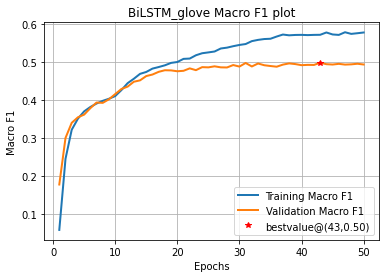